In [4]:
!pip install gdown

In [2]:
!gdown "19vWwsNfrU5W3GMJrb2RLOoZbVAFRQ6P7"

Downloading...
From: https://drive.google.com/uc?id=19vWwsNfrU5W3GMJrb2RLOoZbVAFRQ6P7
To: /content/data.zip
100% 67.0M/67.0M [00:00<00:00, 119MB/s]


In [3]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/lineStrokes/l01/l01-076/l01-076z-02.xml  
  inflating: data/lineStrokes/l01/l01-076/l01-076z-03.xml  
  inflating: data/lineStrokes/l01/l01-076/l01-076z-04.xml  
   creating: data/lineStrokes/l01/l01-083/
  inflating: data/lineStrokes/l01/l01-083/l01-083z-01.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-02.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-03.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-04.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-05.xml  
   creating: data/lineStrokes/l01/l01-091/
  inflating: data/lineStrokes/l01/l01-091/l01-091z-01.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-02.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-03.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-04.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-05.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-06.xml  
  inflating: data/lineS

In [4]:
!pip install svgwrite

     |████████████████████████████████| 67 kB 2.3 MB/s 


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import svgwrite
from IPython.display import SVG, display

import tensorflow as tf
import time


In [3]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

In [4]:
def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))

In [5]:
def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


In [6]:
def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)

In [7]:
def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))

In [8]:
def draw_strokes_pdf(data, param, factor=10, svg_filename='sample_pdf.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    abs_x = 25 - min_x
    abs_y = 25 - min_y

    num_mixture = len(param[0][0])

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        for k in range(num_mixture):
            pi = param[i][0][k]
            if pi > 0.01:  # optimisation, ignore pi's less than 1% chance
                mu1 = param[i][1][k]
                mu2 = param[i][2][k]
                s1 = param[i][3][k]
                s2 = param[i][4][k]
                sigma = np.sqrt(s1 * s2)
                dwg.add(dwg.circle(center=(abs_x + mu1 * factor,
                                           abs_y + mu2 * factor),
                                   r=int(sigma * factor)).fill('red',
                                                               opacity=pi / (sigma * sigma * factor)))

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

    dwg.save()
    display(SVG(dwg.tostring()))


In [9]:
class DataLoader():
    def __init__(
            self,
            batch_size=50,
            seq_length=300,
            scale_factor=10,
            limit=500):
        self.data_dir = "./data"
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.scale_factor = scale_factor  # divide data by this factor
        self.limit = limit  # removes large noisy gaps in the data

        data_file = os.path.join(self.data_dir, "strokes_training_data.cpkl")
        raw_data_dir = self.data_dir + "/lineStrokes"

        if not (os.path.exists(data_file)):
            print("creating training data pkl file from raw source")
            self.preprocess(raw_data_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, data_dir, data_file):
        # create data file from raw xml files from iam handwriting source.

        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = data_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
            #print('Found directory: %s' % dirName)
            for fname in fileList:
                #print('\t%s' % fname)
                filelist.append(dirName + "/" + fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append(
                        [float(point.attrib['x']) - x_offset, float(point.attrib['y']) - y_offset])
                result.append(points)

            return result

        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):

            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j]) - 1)):  # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                print('processing ' + filelist[i])
                strokes.append(
                    convert_stroke_to_array(
                        getStrokes(
                            filelist[i])))

        f = open(data_file, "wb")
        pickle.dump(strokes, f, protocol=2)
        f.close()

    def load_preprocessed(self, data_file):
        f = open(data_file, "rb")
        self.raw_data = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more
        # than seq_length points
        self.data = []
        self.valid_data = []
        counter = 0

        # every 1 in 20 (5%) will be used for validation data
        cur_data_counter = 0
        for data in self.raw_data:
            if len(data) > (self.seq_length + 2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data, dtype=np.float32)
                data[:, 0:2] /= self.scale_factor
                cur_data_counter = cur_data_counter + 1
                if cur_data_counter % 20 == 0:
                    self.valid_data.append(data)
                else:
                    self.data.append(data)
                    # number of equiv batches this datapoint is worth
                    counter += int(len(data) / ((self.seq_length + 2)))

        print("train data: {}, valid data: {}".format(
            len(self.data), len(self.valid_data)))
        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(counter / self.batch_size)

    def validation_data(self):
        # returns validation data
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            data = self.valid_data[i % len(self.valid_data)]
            idx = 0
            x_batch.append(np.copy(data[idx:idx + self.seq_length]))
            y_batch.append(np.copy(data[idx + 1:idx + self.seq_length + 1]))
        return x_batch, y_batch

    def next_batch(self):
        # returns a randomised, seq_length sized portion of the training data
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            data = self.data[self.pointer]
            # number of equiv batches this datapoint is worth
            n_batch = int(len(data) / ((self.seq_length + 2)))
            idx = random.randint(0, len(data) - self.seq_length - 2)
            x_batch.append(np.copy(data[idx:idx + self.seq_length]))
            y_batch.append(np.copy(data[idx + 1:idx + self.seq_length + 1]))
            # adjust sampling probability.
            if random.random() < (1.0 / float(n_batch)):
                # if this is a long datapoint, sample this data more with
                # higher probability
                self.tick_batch_pointer()
        return x_batch, y_batch

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.data)):
            self.pointer = 0

    def reset_batch_pointer(self):
        self.pointer = 0

Streaming output truncated to the last 5000 lines.
processing ./data/lineStrokes/n04/n04-390/n04-390z-04.xml
processing ./data/lineStrokes/n04/n04-390/n04-390z-01.xml
processing ./data/lineStrokes/l09/l09-036/l09-036z-02.xml
processing ./data/lineStrokes/l09/l09-036/l09-036z-01.xml
processing ./data/lineStrokes/l09/l09-036/l09-036z-05.xml
processing ./data/lineStrokes/l09/l09-036/l09-036z-03.xml
processing ./data/lineStrokes/l09/l09-036/l09-036z-04.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-08.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-04.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-07.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-03.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-02.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-06.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-05.xml
processing ./data/lineStrokes/l09/l09-015/l09-015z-01.xml
processing ./data/lineStrokes/l09/l09-994/l09-994z-05.xml
processing ./data/lin

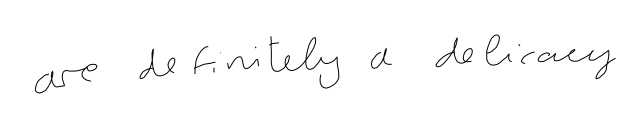

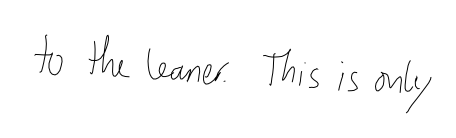

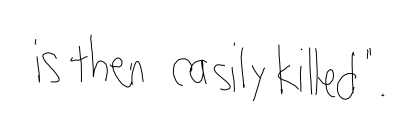

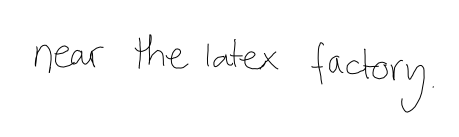

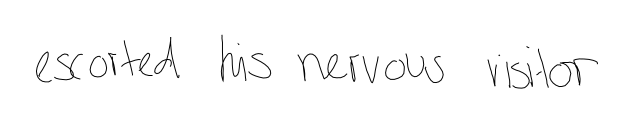

In [13]:
data_loader = DataLoader()
for i in range(5):
  draw_strokes(random.choice(data_loader.raw_data))

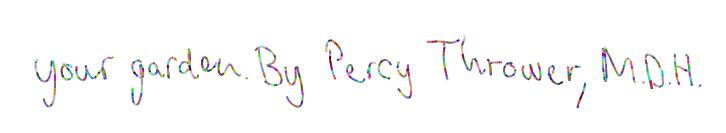

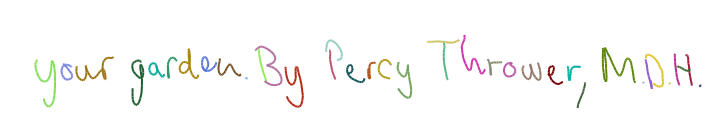

In [14]:
sample = random.choice(data_loader.raw_data)
draw_strokes_random_color(sample, per_stroke_mode = False)
draw_strokes_random_color(sample)


In [10]:
class Model():
    def __init__(self, args, infer=False):
        self.args = args
        if infer:
            args['batch_size'] = 1
            args['seq_length'] = 1

        if args['model'] == 'rnn':
            cell_fn = tf.contrib.rnn.BasicRNNCell
        elif args['model'] == 'gru':
            cell_fn = tf.contrib.rnn.GRUCell
        elif args['model'] == 'lstm':
            cell_fn = tf.contrib.rnn.BasicLSTMCell
        else:
            raise Exception("model type not supported: {}".format(args['model']))

        def get_cell():
            return cell_fn(args['rnn_size'], state_is_tuple=False)

        cell = tf.contrib.rnn.MultiRNNCell(
            [get_cell() for _ in range(args['num_layers'])])

        if (infer == False and args['keep_prob'] < 1):  # training mode
            cell = tf.contrib.rnn.DropoutWrapper(
                cell, output_keep_prob=args['keep_prob'])

        self.cell = cell

        self.input_data = tf.placeholder(
            dtype=tf.float32, shape=[
                None, args['seq_length'], 3], name='data_in')
        self.target_data = tf.placeholder(
            dtype=tf.float32, shape=[
                None,args['seq_length'], 3], name='targets')
        zero_state = cell.zero_state(
            batch_size=args['batch_size'], dtype=tf.float32)
        self.state_in = tf.identity(zero_state, name='state_in')

        self.num_mixture = args['num_mixture']
        # end_of_stroke + prob + 2*(mu + sig) + corr
        NOUT = 1 + self.num_mixture * 6

        with tf.variable_scope('rnnlm'):
            output_w = tf.get_variable("output_w", [args['rnn_size'], NOUT])
            output_b = tf.get_variable("output_b", [NOUT])

        # inputs = tf.split(axis=1, num_or_size_splits=args.seq_length, value=self.input_data)
        # inputs = [tf.squeeze(input_, [1]) for input_ in inputs]
        inputs = tf.unstack(self.input_data, axis=1)

        # outputs, state_out = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, self.state_in, cell, loop_function=None, scope='rnnlm')
        outputs, state_out = tf.contrib.legacy_seq2seq.rnn_decoder(
            inputs, zero_state, cell, loop_function=None, scope='rnnlm')

        output = tf.reshape(
            tf.concat(axis=1, values=outputs), [-1, args['rnn_size']])
        output = tf.nn.xw_plus_b(output, output_w, output_b)
        self.state_out = tf.identity(state_out, name='state_out')

        # reshape target data so that it is compatible with prediction shape
        flat_target_data = tf.reshape(self.target_data, [-1, 3])
        [x1_data, x2_data, eos_data] = tf.split(
            axis=1, num_or_size_splits=3, value=flat_target_data)

        # long method:
        #flat_target_data = tf.split(1, args.seq_length, self.target_data)
        #flat_target_data = [tf.squeeze(flat_target_data_, [1]) for flat_target_data_ in flat_target_data]
        #flat_target_data = tf.reshape(tf.concat(1, flat_target_data), [-1, 3])

        def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
            # eq # 24 and 25 of http://arxiv.org/abs/1308.0850
            norm1 = tf.subtract(x1, mu1)
            norm2 = tf.subtract(x2, mu2)
            s1s2 = tf.multiply(s1, s2)
            z = tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2)) - \
                2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
            negRho = 1 - tf.square(rho)
            result = tf.exp(tf.div(-z, 2 * negRho))
            denom = 2 * np.pi * tf.multiply(s1s2, tf.sqrt(negRho))
            result = tf.div(result, denom)
            return result

        def get_lossfunc(
                z_pi,
                z_mu1,
                z_mu2,
                z_sigma1,
                z_sigma2,
                z_corr,
                z_eos,
                x1_data,
                x2_data,
                eos_data):
            result0 = tf_2d_normal(
                x1_data,
                x2_data,
                z_mu1,
                z_mu2,
                z_sigma1,
                z_sigma2,
                z_corr)
            # implementing eq # 26 of http://arxiv.org/abs/1308.0850
            epsilon = 1e-20
            result1 = tf.multiply(result0, z_pi)
            result1 = tf.reduce_sum(result1, 1, keep_dims=True)
            # at the beginning, some errors are exactly zero.
            result1 = -tf.log(tf.maximum(result1, 1e-20))

            result2 = tf.multiply(z_eos, eos_data) + \
                tf.multiply(1 - z_eos, 1 - eos_data)
            result2 = -tf.log(result2)

            result = result1 + result2
            return tf.reduce_sum(result)

        # below is where we need to do MDN splitting of distribution params
        def get_mixture_coef(output):
            # returns the tf slices containing mdn dist params
            # ie, eq 18 -> 23 of http://arxiv.org/abs/1308.0850
            z = output
            z_eos = z[:, 0:1]
            z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = tf.split(
                axis=1, num_or_size_splits=6, value=z[:, 1:])

            # process output z's into MDN paramters

            # end of stroke signal
            z_eos = tf.sigmoid(z_eos)  # should be negated, but doesn't matter.

            # softmax all the pi's:
            max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
            z_pi = tf.subtract(z_pi, max_pi)
            z_pi = tf.exp(z_pi)
            normalize_pi = tf.reciprocal(
                tf.reduce_sum(z_pi, 1, keep_dims=True))
            z_pi = tf.multiply(normalize_pi, z_pi)

            # exponentiate the sigmas and also make corr between -1 and 1.
            z_sigma1 = tf.exp(z_sigma1)
            z_sigma2 = tf.exp(z_sigma2)
            z_corr = tf.tanh(z_corr)

            return [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos]

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2,
            o_corr, o_eos] = get_mixture_coef(output)

        # I could put all of these in a single tensor for reading out, but this
        # is more human readable
        data_out_pi = tf.identity(o_pi, "data_out_pi")
        data_out_mu1 = tf.identity(o_mu1, "data_out_mu1")
        data_out_mu2 = tf.identity(o_mu2, "data_out_mu2")
        data_out_sigma1 = tf.identity(o_sigma1, "data_out_sigma1")
        data_out_sigma2 = tf.identity(o_sigma2, "data_out_sigma2")
        data_out_corr = tf.identity(o_corr, "data_out_corr")
        data_out_eos = tf.identity(o_eos, "data_out_eos")

        # sticking them all (except eos) in one op anyway, makes it easier for freezing the graph later
        # IMPORTANT, this needs to stack the named ops above (data_out_XXX), not the prev ops (o_XXX)
        # otherwise when I freeze the graph up to this point, the named versions will be cut
        # eos is diff size to others, so excluding that
        data_out_mdn = tf.identity([data_out_pi,
                                    data_out_mu1,
                                    data_out_mu2,
                                    data_out_sigma1,
                                    data_out_sigma2,
                                    data_out_corr],
                                   name="data_out_mdn")

        self.pi = o_pi
        self.mu1 = o_mu1
        self.mu2 = o_mu2
        self.sigma1 = o_sigma1
        self.sigma2 = o_sigma2
        self.corr = o_corr
        self.eos = o_eos

        lossfunc = get_lossfunc(
            o_pi,
            o_mu1,
            o_mu2,
            o_sigma1,
            o_sigma2,
            o_corr,
            o_eos,
            x1_data,
            x2_data,
            eos_data)
        self.cost = lossfunc / (args['batch_size'] * args['seq_length'])

        self.train_loss_summary = tf.summary.scalar('train_loss', self.cost)
        self.valid_loss_summary = tf.summary.scalar(
            'validation_loss', self.cost)

        self.lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self.cost, tvars), args['grad_clip'])
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    def sample(self, sess, num=1200):

        def get_pi_idx(x, pdf):
            N = pdf.size
            accumulate = 0
            for i in range(0, N):
                accumulate += pdf[i]
                if (accumulate >= x):
                    return i
            print('error with sampling ensemble')
            return -1

        def sample_gaussian_2d(mu1, mu2, s1, s2, rho):
            mean = [mu1, mu2]
            cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
            x = np.random.multivariate_normal(mean, cov, 1)
            return x[0][0], x[0][1]

        prev_x = np.zeros((1, 1, 3), dtype=np.float32)
        prev_x[0, 0, 2] = 1  # initially, we want to see beginning of new stroke
        prev_state = sess.run(self.cell.zero_state(1, tf.float32))

        strokes = np.zeros((num, 3), dtype=np.float32)
        mixture_params = []

        for i in range(num):

            feed = {self.input_data: prev_x, self.state_in: prev_state}

            [o_pi,
             o_mu1,
             o_mu2,
             o_sigma1,
             o_sigma2,
             o_corr,
             o_eos,
             next_state] = sess.run([self.pi,
                                     self.mu1,
                                     self.mu2,
                                     self.sigma1,
                                     self.sigma2,
                                     self.corr,
                                     self.eos,
                                     self.state_out],
                                    feed)

            idx = get_pi_idx(random.random(), o_pi[0])

            eos = 1 if random.random() < o_eos[0][0] else 0

            next_x1, next_x2 = sample_gaussian_2d(
                o_mu1[0][idx], o_mu2[0][idx], o_sigma1[0][idx], o_sigma2[0][idx], o_corr[0][idx])

            strokes[i, :] = [next_x1, next_x2, eos]

            params = [
                o_pi[0],
                o_mu1[0],
                o_mu2[0],
                o_sigma1[0],
                o_sigma2[0],
                o_corr[0],
                o_eos[0]]
            mixture_params.append(params)

            prev_x = np.zeros((1, 1, 3), dtype=np.float32)
            prev_x[0][0] = np.array([next_x1, next_x2, eos], dtype=np.float32)
            prev_state = next_state

        strokes[:, 0:2] *= self.args['data_scale']
        return strokes, mixture_params

In [11]:
args = {}
args['rnn_size'] = 256
args['num_layers'] = 2
args['model'] = 'lstm'
args['batch_size'] = 512
args['seq_length'] = 300
args['num_epochs'] = 30
args['save_every'] = 500
args['model_dir'] = 'save'
args['grad_clip'] = 10.0
args['learning_rate'] = 0.005
args['decay_rate'] = 0.95
args['num_mixture'] = 20
args['data_scale'] = 20
args['keep_prob'] = 0.8

In [12]:
data_loader = DataLoader(args['batch_size'], args['seq_length'], args['data_scale'])

if args['model_dir'] != '' and not os.path.exists(args['model_dir']):
    os.makedirs(args['model_dir'])

with open(os.path.join(args['model_dir'], 'config.pkl'), 'wb') as f:
    pickle.dump(args, f)

model = Model(args)

train_losses = []
valid_losses = []

with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(
        os.path.join(args['model_dir'], 'log'), sess.graph)
    train_l = 0
    valid_l = 0
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    for e in range(args['num_epochs']):
        sess.run(tf.assign(model.lr,
                            args['learning_rate'] * (args['decay_rate'] ** e)))
        data_loader.reset_batch_pointer()
        v_x, v_y = data_loader.validation_data()
        valid_feed = {
            model.input_data: v_x,
            model.target_data: v_y,
            model.state_in: model.state_in.eval()}
        state = model.state_in.eval()
        for b in range(data_loader.num_batches):
            ith_train_step = e * data_loader.num_batches + b
            start = time.time()
            x, y = data_loader.next_batch()
            feed = {
                model.input_data: x,
                model.target_data: y,
                model.state_in: state}
            train_loss_summary, train_loss, state, _ = sess.run(
                [model.train_loss_summary, model.cost, model.state_out, model.train_op], feed)
            summary_writer.add_summary(train_loss_summary, ith_train_step)

            valid_loss_summary, valid_loss, = sess.run(
                [model.valid_loss_summary, model.cost], valid_feed)
            summary_writer.add_summary(valid_loss_summary, ith_train_step)

            end = time.time()
            print(
                "{}/{} (epoch {}), train_loss = {:.3f}, valid_loss = {:.3f}, time/batch = {:.3f}"
                .format(
                    ith_train_step,
                    args['num_epochs'] * data_loader.num_batches,
                    e,
                    train_loss,
                    valid_loss,
                    end - start))
            train_l = train_loss
            valid_l = valid_loss
            if (ith_train_step %
                    args['save_every'] == 0) and (ith_train_step > 0):
                checkpoint_path = os.path.join(
                    args['model_dir'], 'model.ckpt')
                saver.save(
                    sess,
                    checkpoint_path,
                    global_step=ith_train_step)
                print("model saved to {}".format(checkpoint_path))
        train_losses.append(train_l)
        valid_losses.append(valid_l)      

train data: 11035, valid data: 580
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

In [28]:
import matplotlib.pyplot as plt
plt.plot(range(30), train_losses)
plt.plot(range(30), valid_losses, c='#00ff00')
plt.xlim(0, 30)
plt.ylim(-5.0, 5.0)
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.savefig('Generation'+'.png')
plt.close()

In [26]:
sample_args = {}
sample_args['filename'] = 'trained_samples'
sample_args['sample_length'] = 500
sample_args['model_dir'] = 'save'
sample_args['scale_factor'] = 10


In [18]:
with open(os.path.join('save', 'config.pkl'), 'rb') as f:
    saved_args = pickle.load(f)

In [19]:
tf.reset_default_graph()

In [20]:
model = Model(saved_args, True)
sess = tf.InteractiveSession()
#saver = tf.train.Saver(tf.all_variables())
saver = tf.train.Saver()


In [21]:
ckpt = tf.train.get_checkpoint_state(sample_args['model_dir'])
print("loading model: ", ckpt.model_checkpoint_path)

saver.restore(sess, ckpt.model_checkpoint_path)

loading model:  save/model.ckpt-1000
INFO:tensorflow:Restoring parameters from save/model.ckpt-1000


In [13]:
!zip -r /content/save.zip /content/save

  adding: content/save/ (stored 0%)
  adding: content/save/model.ckpt-1000.data-00000-of-00001 (deflated 6%)
  adding: content/save/model.ckpt-500.data-00000-of-00001 (deflated 6%)
  adding: content/save/checkpoint (deflated 58%)
  adding: content/save/.ipynb_checkpoints/ (stored 0%)
  adding: content/save/model.ckpt-1000.index (deflated 40%)
  adding: content/save/model.ckpt-1000.meta (deflated 95%)
  adding: content/save/model.ckpt-500.meta (deflated 95%)
  adding: content/save/model.ckpt-500.index (deflated 40%)
  adding: content/save/log/ (stored 0%)
  adding: content/save/log/events.out.tfevents.1651559559.9829d30a64cc (deflated 94%)
  adding: content/save/log/.ipynb_checkpoints/ (stored 0%)
  adding: content/save/config.pkl (deflated 25%)


In [14]:
from google.colab import files
files.download("/content/save.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
def sample_stroke():
    [strokes, params] = model.sample(sess, sample_args['sample_length'])
    draw_strokes(
        strokes,
        factor=sample_args['scale_factor'],
        svg_filename=sample_args['filename'] +
        '.normal.svg')
    draw_strokes_random_color(
        strokes,
        factor=sample_args['scale_factor'],
        svg_filename=sample_args['filename'] +
        '.color.svg')
    draw_strokes_random_color(
        strokes,
        factor=sample_args['scale_factor'],
        per_stroke_mode=False,
        svg_filename=sample_args['filename'] +
        '.multi_color.svg')
    draw_strokes_eos_weighted(
        strokes,
        params,
        factor=sample_args['scale_factor'],
        svg_filename=sample_args['filename'] +
        '.eos_pdf.svg')
    draw_strokes_pdf(
        strokes,
        params,
        factor=sample_args['scale_factor'],
        svg_filename=sample_args['filename'] +
        '.pdf.svg')
    return [strokes, params]


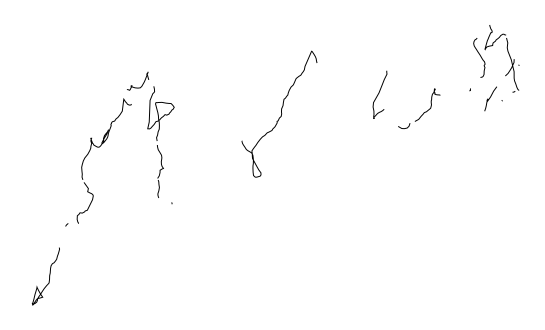

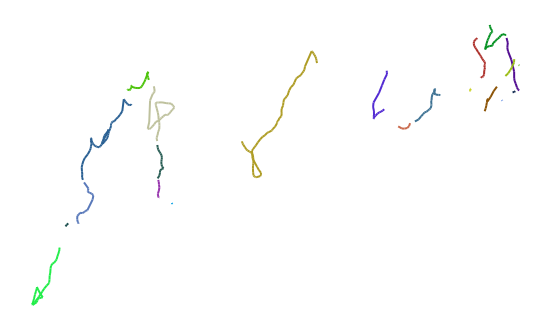

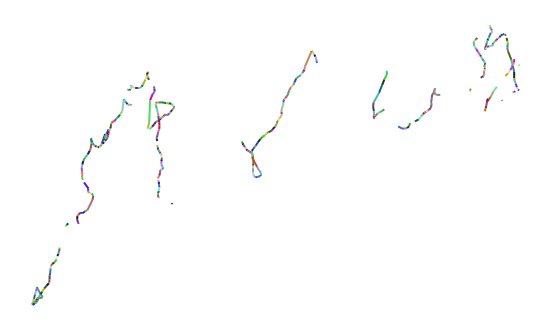

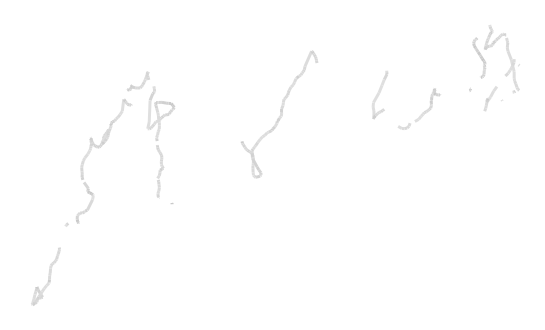

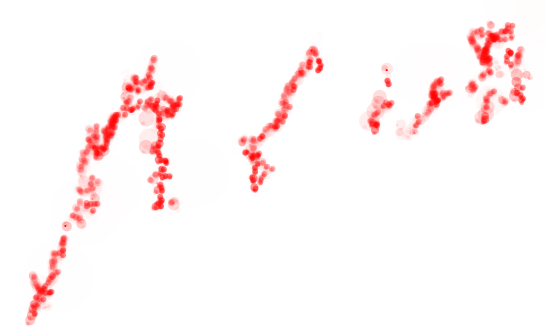

In [27]:
[strokes, params] = sample_stroke()